In [1]:
# Import necessary libraries
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import silhouette_score

In [2]:
# Load the CSV file
file_path = '/content/past_projects.csv'  # Replace with your file path
projects_df = pd.read_csv(file_path, encoding='ISO-8859-1', on_bad_lines='skip')

# Combine 'description' and 'keywords' for each project
projects_df['text'] = projects_df['description'].fillna('') + ' ' + projects_df['keywords'].fillna('')

# Clustring
We used clustering as a way to explore and understand the natural groupings within the projects. This helped us establish a baseline for categorization by identifying patterns and similarities without relying on predefined categories. The clusters gave us insights into how projects naturally group together, which informed and guided the creation of more meaningful and structured categories.

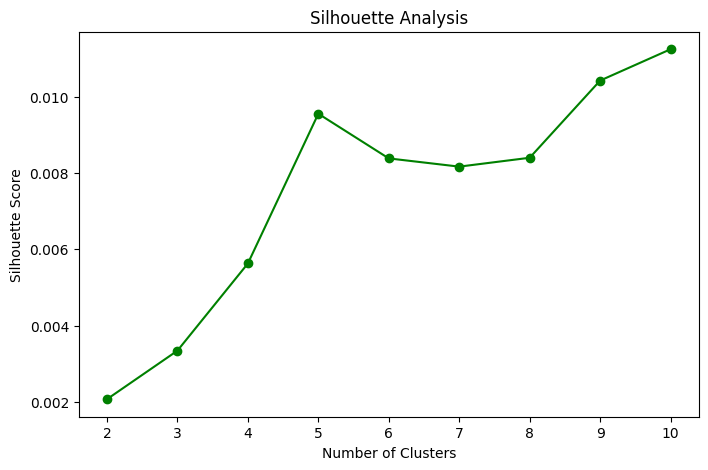

Optimal Number of Clusters: 10
Cluster 0: job, travel, storage, planning, texel, sharing, recommendations, maps, personalized, ai
Cluster 1: tourism, phishing, pet, recommender, property, saudi, adoption, attractions, reviews, riyadh
Cluster 2: data, job, analysis, business, dataset, grn, healthcare, efficiency, patient, gene
Cluster 3: school, parents, children, child, parent, pickup, student, payment, schools, iot
Cluster 4: storytelling, language, techù, images, narrative, illustrated, image generation, creativity, language development, language processing
Cluster 5: vehicle, gas, detection, al, traffic, violation, gas station, fuel, tawaf, consumption
Cluster 6: food, waste, air, air quality, mosque, quality, community, building, smart, time data
Cluster 7: health, yoga, pregnancy, goals, life, mental, mental health, maternal, tracking, progress
Cluster 8: students, academic, lost, key, private, faculty, tutors, advising, projects, campus
Cluster 9: learning, educational, therapy, 

In [3]:

# Load the CSV file
file_path = '/content/past_projects.csv'  # Replace with your file path
projects_df = pd.read_csv(file_path, encoding='ISO-8859-1', on_bad_lines='skip')

# Combine 'discription' and 'keywords' for TF-IDF
if 'keywords' in projects_df.columns:
    projects_df['text'] = projects_df['description'].fillna('') + ' ' + projects_df['keywords'].fillna('')
else:
    projects_df['text'] = projects_df['description'].fillna('')

# Step 1: Preprocess Text Data
custom_stop_words = ['file', 'items', 'app', 'arabia', 'users', 'user', 'models', 'arabic', 'king', 'saud', 'university', 'ksu', 'qusasa']

# Combine with existing English stop words
tfidf_vectorizer = TfidfVectorizer(stop_words='english')  # Load default stop words
default_stop_words = tfidf_vectorizer.get_stop_words()
all_stop_words = list(default_stop_words.union(set(custom_stop_words)))

# Reinitialize the vectorizer with updated stop words
tfidf_vectorizer = TfidfVectorizer(stop_words=all_stop_words, max_features=1000, ngram_range=(1, 2))
tfidf_matrix = tfidf_vectorizer.fit_transform(projects_df['text'])

# Step 2: Hyperparameter Tuning to Determine Optimal Clusters
def evaluate_kmeans(tfidf_matrix, max_clusters=10):
    silhouette_scores = []
    cluster_range = range(2, max_clusters + 1)

    for n_clusters in cluster_range:
        kmeans = KMeans(n_clusters=n_clusters, random_state=42)
        cluster_labels = kmeans.fit_predict(tfidf_matrix)
        silhouette_avg = silhouette_score(tfidf_matrix, cluster_labels)
        silhouette_scores.append(silhouette_avg)

    return cluster_range, silhouette_scores

# Determine the optimal number of clusters
max_clusters = min(10, len(projects_df) - 1)  # Ensure max_clusters <= number of projects - 1
if max_clusters < 2:
    raise ValueError("Not enough projects to perform clustering. At least 2 are required.")

cluster_range, silhouette_scores = evaluate_kmeans(tfidf_matrix, max_clusters=max_clusters)

# Plot silhouette scores
plt.figure(figsize=(8, 5))
plt.plot(cluster_range, silhouette_scores, marker='o', color='green')
plt.title('Silhouette Analysis')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.xticks(cluster_range)
plt.show()

# Select optimal number of clusters
optimal_clusters = cluster_range[np.argmax(silhouette_scores)]
print(f"Optimal Number of Clusters: {optimal_clusters}")

# Step 3: Perform KMeans Clustering
kmeans = KMeans(n_clusters=optimal_clusters, random_state=42)
projects_df['cluster'] = kmeans.fit_predict(tfidf_matrix)

# Step 4: Extract Top Keywords for Each Cluster
def get_top_keywords(tfidf_matrix, kmeans, n_terms=10):
    centroids = kmeans.cluster_centers_
    terms = tfidf_vectorizer.get_feature_names_out()
    keywords = []
    for cluster_num in range(len(centroids)):
        cluster_terms = centroids[cluster_num].argsort()[-n_terms:][::-1]
        keywords.append([terms[i] for i in cluster_terms])
    return keywords

top_keywords = get_top_keywords(tfidf_matrix, kmeans)

# Display top keywords for each cluster
for i, keywords in enumerate(top_keywords):
    print(f"Cluster {i}: {', '.join(keywords)}")

# Testing Section
print("\nTesting: Clustering Results")

# 1. Display a few samples from each cluster
for cluster_id in range(optimal_clusters):
    print(f"\nCluster {cluster_id}:")
    cluster_samples = projects_df[projects_df['cluster'] == cluster_id].head(3)  # Display up to 3 samples per cluster
    for _, row in cluster_samples.iterrows():
        print(f" - Project: {row['text']}")

# 2. Count the number of projects in each cluster
cluster_counts = projects_df['cluster'].value_counts()
print("\nCluster Distribution:")
print(cluster_counts)

# 3. Validate Silhouette Score
silhouette_avg = silhouette_score(tfidf_matrix, kmeans.labels_)
print(f"\nSilhouette Score for Optimal Clusters ({optimal_clusters}): {silhouette_avg:.3f}")


# Classification
we used classification to assign projects into a predefined categories based on their keywords, providing a more organized and consistent way to label and group the projects.

In [4]:
#Classification
categories = {
    "Human Resources": ["job", "recruitment", "seekers", "career", "hiring"],
    "Entertainment": ["tourism", "games", "entertainment", "engagement"],
    "Children": ["children", "school", "parents", "child"],
    "Security": ["security", "encryption", "steganography", "privacy", "phishing"],
    "Health": ["health", "patient", "therapy", "maternal", "rehabilitation", "medication"],
    "Academic Solutions": ["academic", "education", "learning", "students", "study"],
    "Smart Cities & Environment": ["environment", "air", "monitoring", "smart", "sustainability", "traffic", "gas", "waste", "pollution", "property", "housing", "building","animal","plants"],
    "Data Analysis": ["analysis", "datasets", "insights", "analytics"]
}

# Function to map projects to categories based on the 'keywords' column
def assign_category(row):
    project_keywords = str(row['keywords']).lower()  # Convert keywords to lowercase
    for category, keywords in categories.items():
        if any(keyword in project_keywords for keyword in keywords):
            return category
    return "Uncategorized"  # For projects that don't match any category

# Apply the function to the DataFrame
projects_df['category'] = projects_df.apply(assign_category, axis=1)

# Group and display projects by category with their names and descriptions
grouped_projects = projects_df.groupby('category')

for category, group in grouped_projects:
    print(f"\nCategory: {category}")
    for _, row in group.iterrows():
        print(f" - {row['name']}: {row['description']}")

# Testing: Evaluate missed projects (Uncategorized)
if "Uncategorized" in grouped_projects.groups:
    print("\nTesting: Displaying a few uncategorized projects...")
    uncategorized_projects = grouped_projects.get_group("Uncategorized").head(5)
    for _, row in uncategorized_projects.iterrows():
        print(f" - {row['name']}: {row['description']}")



Category: Academic Solutions
 - Business Gate: The Business Gate is a comprehensive platform designed to enhance the operational efficiency of Business Units (BUs) at King Saud University (KSU) in alignment with Saudi Arabia's Vision 2030. This workflow management system includes a web-based application and a mobile app, addressing communication gaps and resource management issues faced by BUs. By streamlining daily operations, facilitating project assignments, and improving communication, Business Gate will enable KSU to promote sustainable development and innovation while effectively managing the complexities of educational and consultancy services.
 - TeXel: Texel is an innovative mobile application designed to address the challenges faced by technology professionals and enthusiasts in navigating the complex landscape of technical information and assistance. By consolidating features from various platforms into a single, user-friendly interface, Texel enhances productivity, collabo